### RAG With Persistance Memory Using LangGraph

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain.chat_models import init_chat_model

llm=init_chat_model("groq:openai/gpt-oss-20b")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000026A0032B510>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000026A0044B350>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
from langchain_community.embeddings import FastEmbedEmbeddings
embeddings=FastEmbedEmbeddings()
embeddings

FastEmbedEmbeddings(model_name='BAAI/bge-small-en-v1.5', max_length=512, cache_dir=None, threads=None, doc_embed_type='default', batch_size=256, parallel=None, providers=None, model=<fastembed.text.text_embedding.TextEmbedding object at 0x0000026A00538F50>)

In [4]:
## Document Ingestion And Processing
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [6]:
## chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
all_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [7]:
## Vector Store

from langchain_community.vectorstores import FAISS
vector_store=FAISS.from_documents(
    documents=all_splits,
    embedding=embeddings
)
print(f"Vector store created with {vector_store.index.ntotal} vectors")

Vector store created with 63 vectors


In [9]:
from langchain_classic.agents import tool

In [10]:
@tool()
def retrieve(query:str):
    """Retrieve the information related to the query"""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [11]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [12]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [13]:
# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])
tools

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'runtime': ('N/A', <class 'inspect._empty'>)}, _tools_by_name={'retrieve': StructuredTool(name='retrieve', description='Retrieve the information related to the query', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x0000026A4ADEE8E0>)}, _tool_to_state_args={'retrieve': {}}, _tool_to_store_arg={'retrieve': None}, _tool_to_runtime_arg={'retrieve': None}, _handle_tool_errors=<function _default_handle_tool_errors at 0x0000026A4A7BD580>, _messages_key='messages', _wrap_tool_call=None, _awrap_tool_call=None)

In [14]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

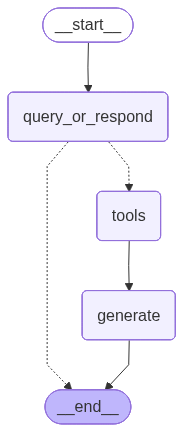

In [15]:
# Build graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
graph

In [17]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [18]:
input_message="Hello"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()
    

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [19]:
vector_store.similarity_search("What is TAsk Decomposition")

[Document(id='61ed4934-8c52-43f5-8532-3f1b906b7c6b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-f

In [20]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

**Task Decomposition** is the systematic process of breaking a complex, multi‑step activity into smaller, more manageable, and well‑defined sub‑tasks.  
The goal is to make a big problem easier to understand, plan, assign, execute, and evaluate.

---

## 1. Why Decompose Tasks?

| Problem | Decomposition Benefit |
|---------|-----------------------|
| **Ambiguity** | Clarifies what “the task” really means. |
| **Scope creep** | Limits the scope to concrete deliverables. |
| **Scheduling** | Allows parallel work streams and realistic timelines. |
| **Resource allocation** | Matches specific skills to specific subtasks. |
| **Risk management** | Identifies high‑risk components early. |
| **Monitoring** | Enables milestone tracking and progress reporting. |

---

## 2. Core Concepts

| Concept | What

In [21]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (fc_3ad1e355-518d-4eef-ab00-e42ba0b6054f)
 Call ID: fc_3ad1e355-518d-4eef-ab00-e42ba0b6054f
  Args:
    query: common ways of doing task decomposition
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT tr

In [22]:
### Conversation History
chat_history=graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?
================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

**Task Decomposition** is the systematic process of breaking a complex, multi‑step activity into smaller, more manageable, and well‑defined sub‑tasks.  
The goal is to make a big problem easier to understand, plan, assign, execute, and evaluate.

---

## 1. Why Decompose Tasks?

| Problem | Decomposition Benefit |
|---------|-----------------------|
| **Ambiguity** | Clarifies what “the task” really means. |
| **Scope creep** | Limits the scope to concrete deliverables. |
| **Scheduling** | Allows parallel work streams and realistic timelines. |
| **Resource allocation** | Matches specific skills t

### ReAct Agent Architecture-Persistant Memory

In [23]:
retrieve

StructuredTool(name='retrieve', description='Retrieve the information related to the query', args_schema=<class 'langchain_core.utils.pydantic.retrieve'>, func=<function retrieve at 0x0000026A4ADEE8E0>)

In [24]:
from langchain.agents import create_agent
memory = MemorySaver()
agent_executor=create_agent(llm,[retrieve],checkpointer=memory)

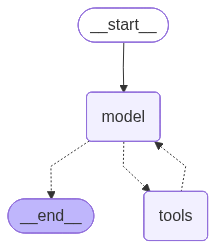

In [25]:
agent_executor

In [26]:
config = {"configurable": {"thread_id": "def234"}}

In [27]:
input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

In [ ]:
for event in agent_executor.stream({"messages": [{"role": "user", "content": input_message}]},
                                   stream_mode="values",
                                   config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (fc_ae1eec92-916d-423d-8a34-d9b16997b2db)
 Call ID: fc_ae1eec92-916d-423d-8a34-d9b16997b2db
  Args:
    query: Hierarchical Task Analysis extensions HTA+S HTA+R HTA+F common extensions
================================= Tool Message =================================
Name: retrieve

("Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}\nContent: Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot 

In [33]:
from pprint import pprint

msg=(agent_executor.stream({"messages": [{"role": "user", "content": "What was my last question"}]},
                                   stream_mode="values",
                                   config=config))

for i in msg:
    pprint(i)

{'messages': [HumanMessage(content='What is the standard method for Task Decomposition?\n\nOnce you get the answer, look up common extensions of that method.', additional_kwargs={}, response_metadata={}, id='06b913db-456b-431c-94a9-61af6479581b'),
              AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to answer: "What is the standard method for Task Decomposition? Once you get the answer, look up common extensions of that method." So we need to identify the standard method for task decomposition. In software engineering, task decomposition refers to breaking down tasks into subtasks. There\'s a standard method: "Task Decomposition using Hierarchical Task Analysis (HTA)" or "Task Decomposition using Functional Decomposition" or "Task Decomposition using Work Breakdown Structure (WBS)". In HCI, "Task Decomposition" often uses "Hierarchical Task Analysis". In software architecture, "Task decomposition" often uses "Functional decomposition" or "Object-oriented